In [51]:
# https://www.tensorflow.org/tutorials/keras/regression

from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os

In [44]:


column_names = ['fileId', 'row','rising_idx','falling_idx','volume','rising_weight',
                'falling_weight', 'delay']

raw_dataset = pd.read_csv('../preprocessing/processed_baby.csv', names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, usecols = column_names[1:])

dataset = raw_dataset.copy()
dataset.tail()

dataset = dataset.dropna()
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
# sns.pairplot(train_dataset[["row","rising_idx", "falling_idx", "volume", "rising_weight", "falling_weight", "delay"]], diag_kind="kde")
train_stats = train_dataset.describe()
train_stats.pop("delay")
train_stats = train_stats.transpose()
train_stats
train_labels = train_dataset.pop('delay')
test_labels = test_dataset.pop('delay')





In [63]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

def train_model(x,y,degree):
  model = np.polyfit(x,y,degree)
  return model

def predict(pt, rising_model, falling_model):
    tyr = np.sum([m * math.pow(pt['rising_idx'],i) for i,m in enumerate(rising_model[::-1])])
    tyf = np.sum([m * math.pow(pt['falling_idx'],i) for i,m in enumerate(falling_model[::-1])])
    return (tyr + tyf) / 2
    
rising_model = train_model(train_dataset['rising_idx'], train_labels, 3)
print('val rising_model = Seq(%s)' % ','.join([str(x) + '.to[T]' for x in rising_model]))
falling_model = train_model(train_dataset['falling_idx'], train_labels, 3)
print('val falling_model = Seq(%s)' % ','.join([str(x) + '.to[T]' for x in falling_model]))


val rising_model = Seq(2.7127902100930554e-06.to[T],0.0017402301385554485.to[T],-9.748326193440434.to[T],2108.501451402893.to[T])
val falling_model = Seq(-9.49126656694674e-07.to[T],0.004153170356154755.to[T],-9.53119098480341.to[T],3284.9897800437307.to[T])


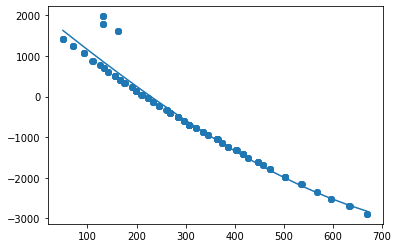

In [64]:
import numpy.polynomial.polynomial as poly
ffit = poly.Polynomial(rising_model[::-1])    # instead of np.poly1d

fig1 = plt.figure()                                                                                           
ax1 = fig1.add_subplot(111)                                                                                   
ax1.scatter(train_dataset['rising_idx'], train_labels)    
s = np.array(sorted(train_dataset['rising_idx'])).astype(float)
plt.plot(s, ffit(s))
plt.show()

In [115]:
# loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

d = [predict(x[1], rising_model, falling_model) for x,y in zip(test_dataset.iterrows(), test_labels)]
mse = np.mean([math.pow(t,2) for t in d])
mae = np.mean([abs(t) for t in d])

print("Testing set Mean Sq Error: {:5.2f} ns".format(mse))
print("Testing set Mean Abs Error: {:5.2f} ns".format(mae))

Testing set Mean Sq Error: 1640461.18 ns
Testing set Mean Abs Error: 1048.20 ns


In [122]:
df2 = pd.DataFrame({"rising_idx":[157],
    "falling_idx":[341],
    "volume":[12039],
    "rising_weight":[35.2498],
    "falling_weight":[-28.1037]})
print(predict(df2, rising_model, falling_model))
print('True label = %f' % 509.093)

555.7806178373594
True label = 509.093000
